In [15]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
import numpy as np

test_data = pd.read_csv("../../CMAPSS/test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("../../CMAPSS/RUL_FD001.txt", sep = "\s+", header = None)

num_test_windows = 5
processed_test_data = []
num_test_windows_list = []
test_data_first_column = test_data[0]


columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]
scaler = StandardScaler()
test_data = scaler.fit_transform(test_data.drop(columns = columns_to_be_dropped))
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

In [16]:
num_test_machines = len(test_data[0].unique())

In [17]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [18]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    #Viene calcolato il numero di batch che saranno generati sulla base della grandezza dell'input 
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    
    #Si recupera il numero di features all'interno del dataframe
    num_features = input_data.shape[1]
    '''
    Qui, viene inizializzata una matrice output_data con valori NaN, che rappresenta i dati di output che verranno generati dalla funzione. 
    La matrice è inizialmente creata come una matrice 3D con dimensioni (num_batches, window_length, num_features) per contenere i batch di dati di input.
    '''
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    
    #Verfico che i labels siano stati forniti
    if target_data is None:
        
        #Iteriamo attraverso i batch e copiamo le finestre temporali corrispondenti dai dati di input input_data nella matrice output_data. 
        #L'output sarà quindi una matrice 3D con i batch di dati di input.

        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        #Nel caso in cui i dati siano forniti semplicemente facciamo la stessa cosa per i dati di target
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))] #Differente perché i dati di target sono formattati in altra maniera.
        return output_data, output_targets

In [19]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [20]:

window_length = 30 #Lunghezza delle sequenze
shift = 1
early_rul = 125 #100 è il valore utilizzato comunemente dallo stato dell'arte             
processed_train_data = []
processed_train_targets = []
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


In [21]:
## Caricamento della rete neurale
from keras import backend as K 
import math 
import tensorflow as tf
@tf.function
def custom_loss2(y_true, y_pred):
    alpha = 0.2
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

@tf.function
def custom_score(y_true, y_pred):
    d_i = y_pred - y_true
    #esponente = tf.where(d_i < 0, 1.0 / (d_i / 13.0), d_i / 10.0)
    sum = tf.reduce_sum(tf.where(d_i < 0, tf.exp(-d_i/13)-1, tf.exp(d_i/10)-1)) #prova
    #sum = tf.reduce_sum(tf.exp(esponente) - 1.0)
    return sum

large_lstm = tf.keras.models.load_model('./models/LSTMlarge/FD0001/', custom_objects={'custom_loss2':custom_loss2, 'custom_score':custom_score})


In [22]:
rul_pred = large_lstm.predict(processed_test_data)

16/16 [==============================] - 1s 11ms/step


In [26]:
import matplotlib.pyplot as plt
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

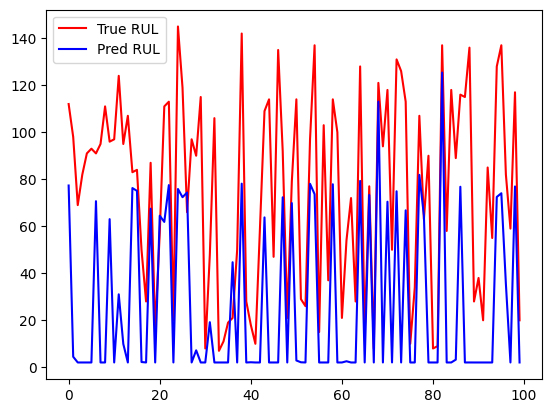

In [27]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
rul_pred = large_lstm.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 15ms/step
RMSE:  59.83951377379206


In [29]:
def compute_s_score(y_true, y_pred):
    d_i = y_pred - y_true
    #esponente = tf.where(d_i < 0, 1.0 / (d_i / 13.0), d_i / 10.0)
    sum = tf.reduce_sum(tf.where(d_i < 0, tf.exp(-d_i/13)-1, tf.exp(d_i/10)-1)) #prova
    #sum = tf.reduce_sum(tf.exp(esponente) - 1.0)
    return sum

s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  tf.Tensor(132161.14639671458, shape=(), dtype=float64)
